In [1]:
import sys
sys.path.append('..')

In [101]:
from importlib import reload
from os.path import exists

import networkx as nx
import numpy as np
import pandas as pd
import lib.obo
import lib.classification.elastic
import lib.classification.validation
import lib.utils
import data

reload(lib.classification.validation)
reload(lib.classification.elastic)
reload(lib.obo)
reload(lib.utils)
reload(data)

from lib.classification.elastic import annotate_index, collapse_matches
from lib.utils import map_series, expand_dataframe, expand, flatten
from lib.classification.validation import correct_ratio, incorrect_ratio
from elasticsearch import Elasticsearch
from lib.obo import read_ontology
pd.set_option('display.width', 512)

In [21]:
import seaborn
%matplotlib inline

In [3]:
larisa_series = data.larisa_series()

larisa_ids = list(map(int, larisa_series.index.unique()))
larisa_vd = pd.DataFrame(dict(classes=larisa_series[['doid']]
                         .reset_index()
                         .groupby('id')['doid']
                         .apply(lambda x: list(set(x)))))
larisa_vd[:7]

,classes
id,
2817,[DOID:0060108]
3292,[DOID:5520]
3467,[DOID:3969]
3744,[DOID:1612]
4107,[DOID:9256]
4183,"[DOID:0050589, DOID:9256, DOID:0050860]"
4290,"[DOID:3069, DOID:3181, DOID:3068]"


In [4]:
es = Elasticsearch()
ontology = read_ontology('../data/geo-annotation/doid.obo',
                         exclude_duplicates=True)

Read obo graph
Name: 
Type: DiGraph
Number of nodes: 6595
Number of edges: 6594
Average in degree:   0.9998
Average out degree:   0.9998


In [369]:
# Убираем синонимы состоящие только из коротких слов  (len <= 2 )
# (вообще ошибка происходит изза стоп-слов в Elasticsearch, но так проще)

def cell():
    import re
    def tokenize(s):
        return re.split(r'[^\w\d]+', s)
    
    def all_short(synonym):
        return all(len(t) <= 2 for t in tokenize(synonym))
    
    for item_id, item in ontology.meta.items():
        item.synonyms = [s for s in item.synonyms if not all_short(s)]

cell()

In [374]:
# Добавляем свои синонимы
ontology.meta['DOID:10534'].synonyms = list(set(ontology.meta['DOID:10534'].synonyms + ['gastric cancer']))
ontology.meta['DOID:9256'].synonyms = list(set(ontology.meta['DOID:10534'].synonyms + ['colorectal carcinoma']))


In [382]:
# Убираем циклические синонимы
def cell():
    s = set(ontology.meta['DOID:0050865'].synonyms)
    s.remove('squamous-cell carcinoma')
    ontology.meta['DOID:0050865'].synonyms = list(s)


In [42]:
annotation_result_file = '../data/geo-annotation/series.disease.res3.pickle'
if not exists(annotation_result_file):
    res = annotate_index(client=es,
                         ontology=ontology,
                         index='series',
                         ids=larisa_ids)

    res.to_pickle(annotation_result_file)

else:
    res = pd.read_pickle(annotation_result_file)

In [250]:
res['classes'] = res['classes'].map(collapse_matches(ontology.graph))

In [283]:
def doid_id(item_id):
    return "DOID:{:07}".format(item_id)


def ontology_name(item_id):
    if item_id not in ontology.meta:
        return item_id
    return ontology.meta[item_id].name


def to_name(series_id):
    return "GSE{}".format(series_id)

def name(item_id):
    return '{} ({})'.format(ontology_name(item_id), item_id)

def names(df):
    return df.applymap(lambda xs: [name(x) for x in xs])

def sub_ontology(nodes, ontology):
    subset = set(flatten([nx.shortest_path(ontology.graph, 'DOID:4', cls) for cls in nodes]))
    for n in nodes:
        subset.add(n)
    return nx.subgraph(ontology.graph, subset)

def matches_graph(matches, vd_classes=None, figsize=None, prog='neato'):
    matches = [m for m in matches if m in ontology.graph.nodes()]
    vd_classes = vd_classes or []
    import matplotlib.pyplot as plt
    figsize = figsize or (14, 10)
    plt.figure(figsize=figsize) 
    import networkx as nx
    
    G = sub_ontology(matches + vd_classes, ontology)
    pos=nx.pygraphviz_layout(G, prog=prog) 
    
    labels = dict((k, v) for (k, v) in names_dict.items() if k in G.nodes())
    nodes_other = [x for x in G.nodes() if x not in matches]
    
    nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='r',
             alpha=0.5,
            nodelist=matches)
    
    nx.draw_networkx(G, labels=labels, 
        pos=pos, 
        node_size=400,
        node_color='w',
         alpha=0.8,
        nodelist=nodes_other)
    
    if vd_classes:
        nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='g',
            alpha=0.5,
#             font_color='g',                     
            nodelist=vd_classes)
        
    plt.show()

    
names_dict = dict((record.id, record.name) for record in ontology.meta.values())

In [251]:
compare = pd.merge(res, larisa_vd, left_index=True, right_index=True, suffixes=('_res', '_vd'))
metrics = pd.DataFrame(dict(
    correct_ratio=correct_ratio(res, larisa_vd),
    incorrect_ratio=incorrect_ratio(res, larisa_vd)
))

In [114]:
# Нужен граф синонимов
expand(names(compare).loc[3292]).sort_index()

classes_res                  squamous cell carcinoma (DOID:1749)
classes_res        tongue squamous cell carcinoma (DOID:0050865)
classes_res                                    cancer (DOID:162)
classes_res         atypical teratoid rhabdoid tumor (DOID:2129)
classes_res                  head and neck carcinoma (DOID:1542)
classes_res    head and neck squamous cell carcinoma (DOID:5520)
classes_res                                 carcinoma (DOID:305)
classes_res                    head and neck cancer (DOID:11934)
classes_res                                papilloma (DOID:2615)
classes_vd                                                   NaN
classes_vd     head and neck squamous cell carcinoma (DOID:5520)
classes_vd                                                   NaN
classes_vd                                                   NaN
classes_vd                                                   NaN
classes_vd                                                   NaN
classes_vd               

In [252]:
metrics.mean()

correct_ratio      0.692850
incorrect_ratio    0.593246
dtype: float64

In [377]:
names(compare).loc[18842].classes_res

['squamous cell carcinoma (DOID:1749)',
 'adenocarcinoma (DOID:299)',
 'lung carcinoma (DOID:3905)',
 'tongue squamous cell carcinoma (DOID:0050865)']

In [379]:
ontology.meta['DOID:0050865'].dict()

{'alt_ids': [],
 'defs': ['A tongue cancer that is located_in the squamous cells of the tongue.'],
 'id': 'DOID:0050865',
 'is_a': 'DOID:8649',
 'is_obsolete': None,
 'name': 'tongue squamous cell carcinoma',
 'relationships': [],
 'subsets': [],
 'synonyms': ['squamous-cell carcinoma'],
 'xrefs': ['ICD10:C44', 'MSH:D002294']}

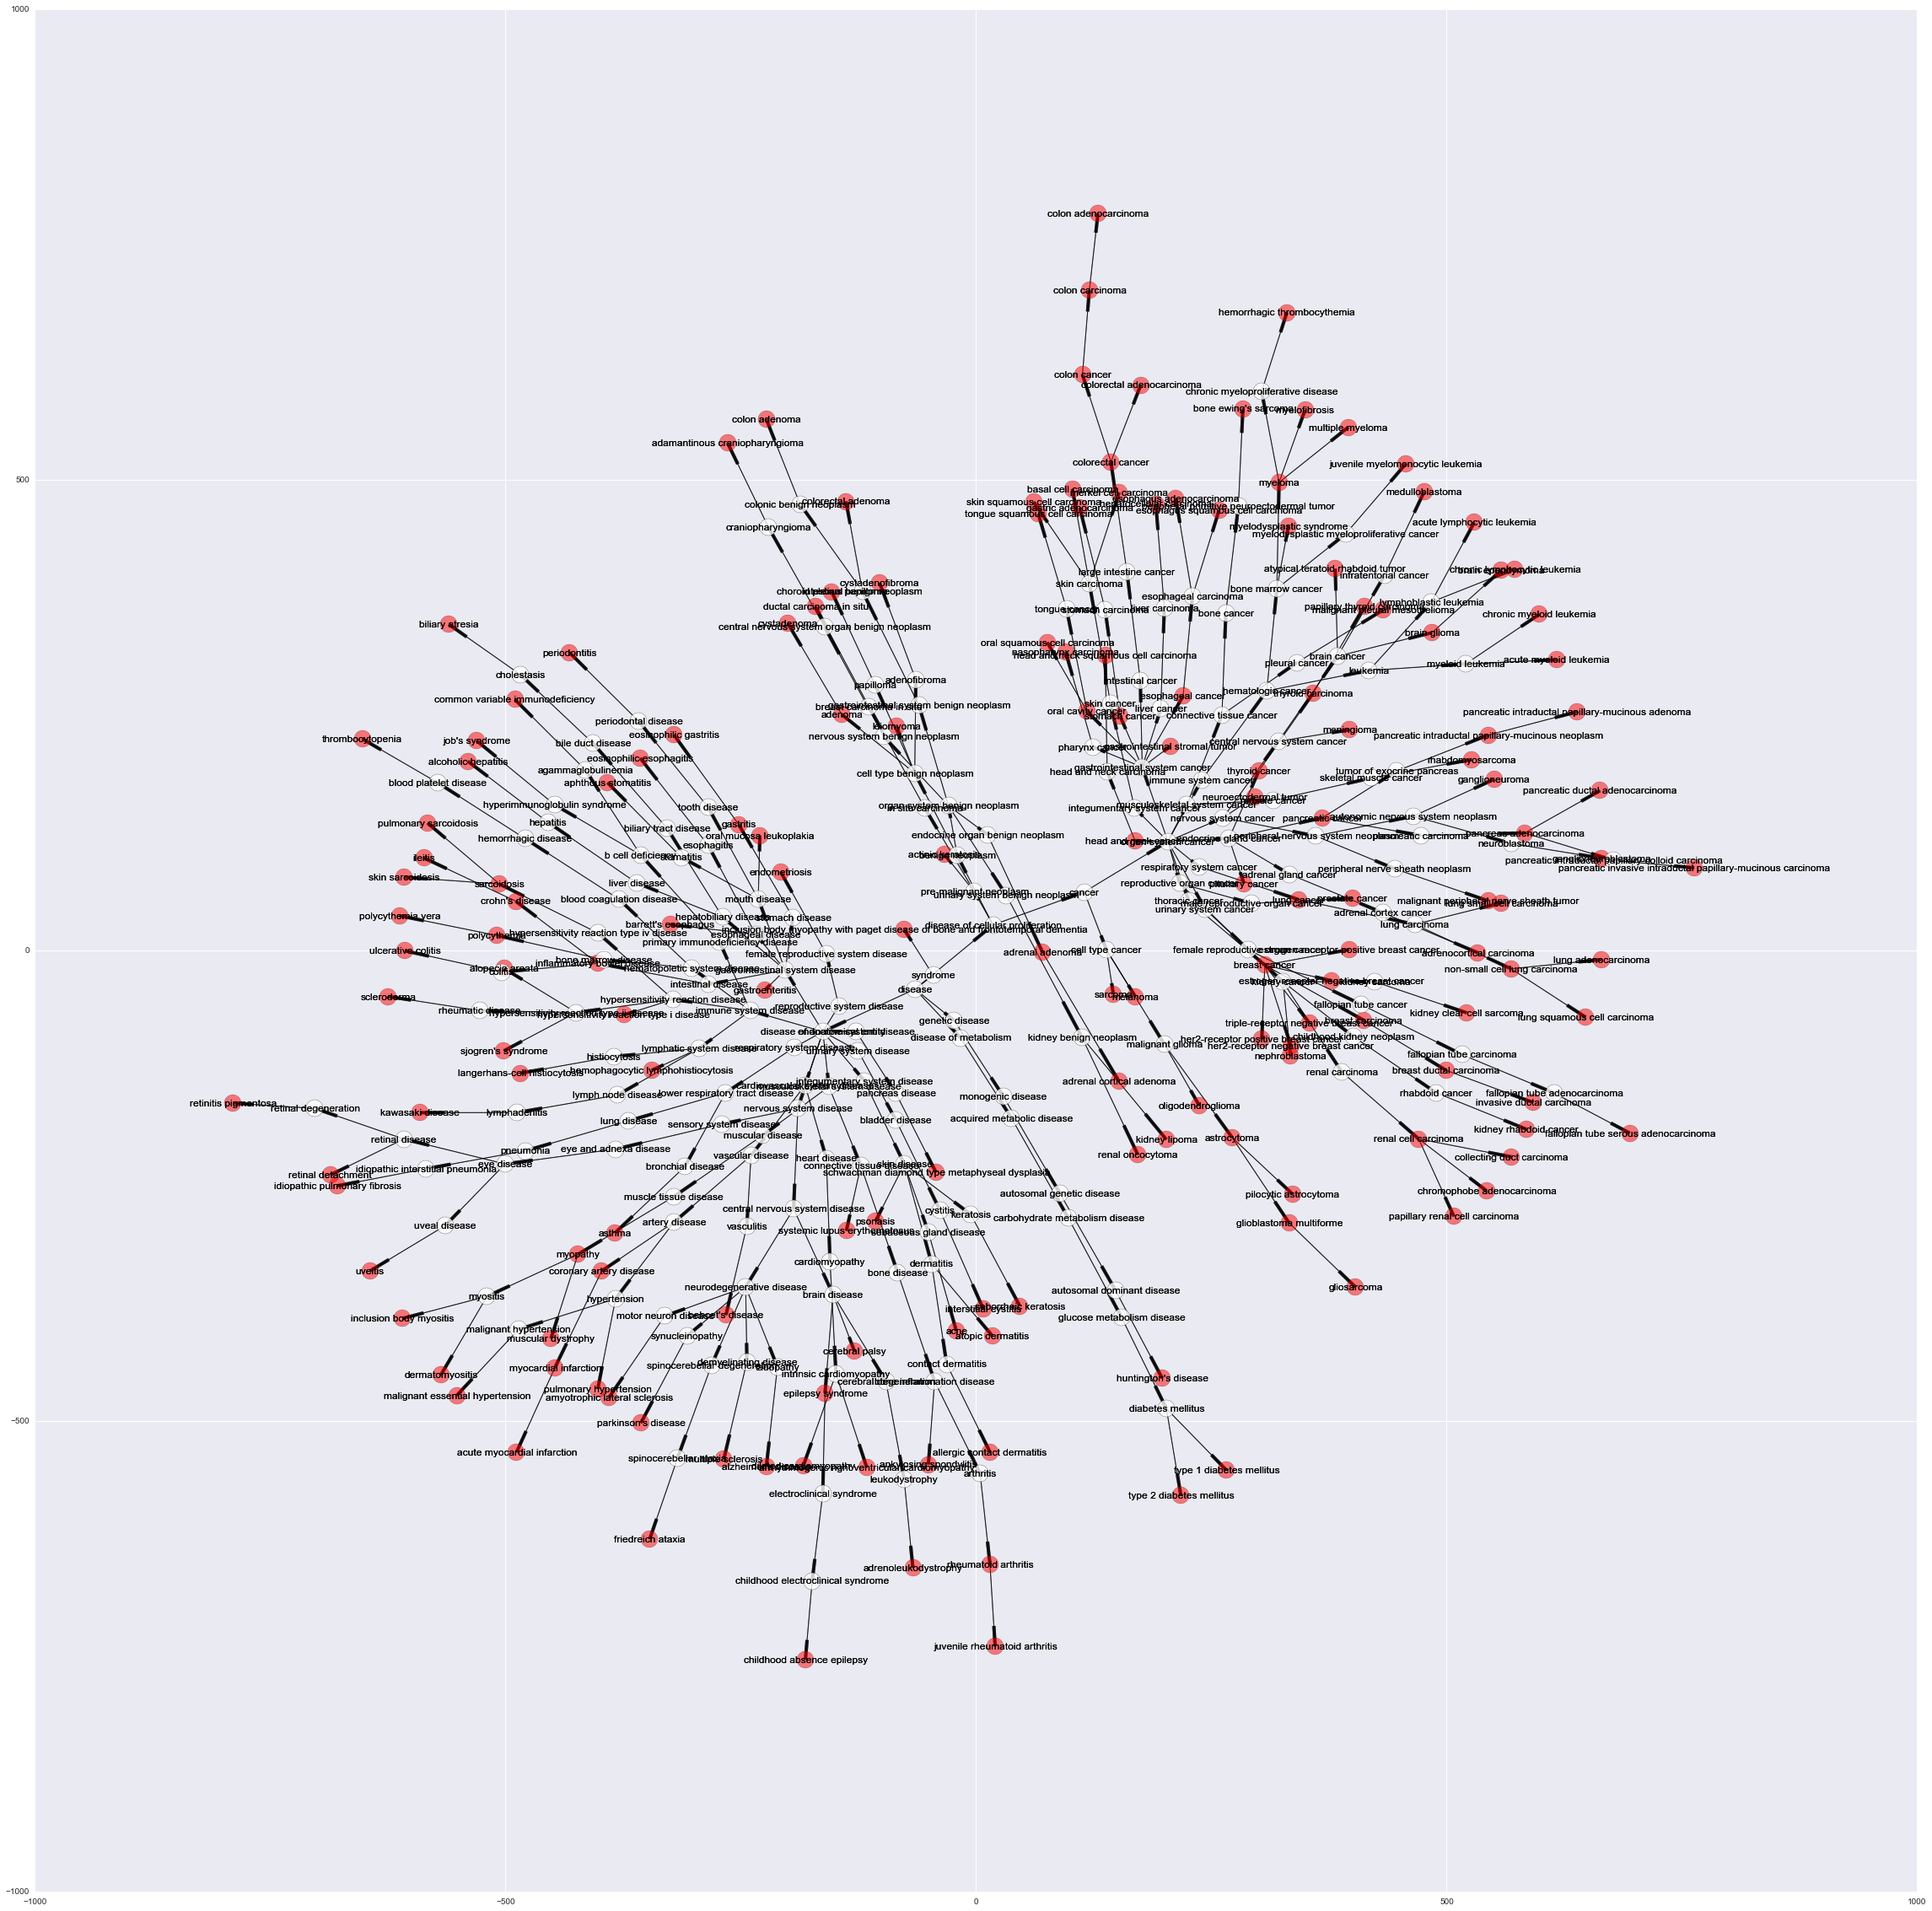

In [241]:
matches_graph(list(expand(larisa_vd.classes).unique()), figsize=(40, 40))

In [294]:
import qgrid
def cell():
    print(metrics[metrics.correct_ratio == 0].shape)
    return metrics[metrics.correct_ratio == 0]
qgrid.show_grid(cell())

(89, 2)


In [318]:
index = 22

31
23806
classes_res           [malignant glioma (DOID:3070)]
classes_vd     [glioblastoma multiforme (DOID:3068)]
Name: 23806, dtype: object


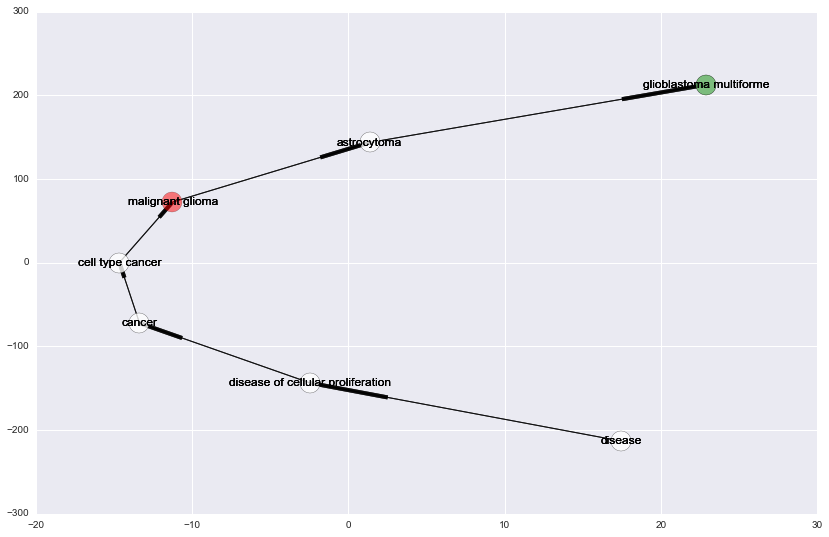

In [329]:
def cell():
    global index
    m = metrics[metrics.correct_ratio == 0].copy()
    i = m.index[index]
    row = compare.loc[i]
    
    print(index)
    print(m.index[index])
    print(names(compare).loc[i])
    index += 1
    matches_graph(row.classes_res, row.classes_vd, figsize=(14, 9))
    
cell()

In [183]:
len(nx.descendants(ontology.graph, 'DOID:0050687')) # cell type cancer,
# A cancer that is classified by the type of cell from which it is derived. 

182

In [185]:
len(nx.descendants(ontology.graph, 'DOID:0050686')) # organ system cancer,
# A cancer that is classified based on the organ it starts in. 

1809

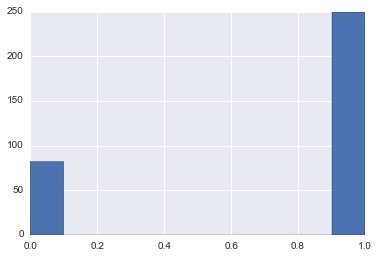

In [23]:
(metrics.incorrect_ratio > 0).hist()

In [330]:
# Проверка на коротнкие синонимы

In [331]:
import re
def tokenize(s):
    return re.split(r'[^\w\d]+', s)

In [370]:
item_tokens = pd.DataFrame.from_records(((item.id, list(set(token for token in tokenize(name) if token))) for item in ontology.items() for name in item.names()),
                                        columns=['id', 'tokens'])
print(item_tokens.shape)
item_tokens[:10]

(17830, 2)


,id,tokens
0,DOID:540,[strabismus]
1,DOID:11427,[endosalpingiosis]
2,DOID:11427,"[endosalpingiosis, disorder]"
3,DOID:3201,"[sympathetic, neurilemmoma]"
4,DOID:1240,[leukemia]
5,DOID:6903,"[eye, lymphoma]"
6,DOID:172,"[acanthoma, clear, cell]"
7,DOID:172,"[acanthoma, clear, disorder, cell]"
8,DOID:172,"[acanthoma, clear, abnormality, morphologic, c..."
9,DOID:172,"[cell, acanthoma, clear, pale]"


In [372]:
item_tokens[item_tokens['tokens'].map(lambda tokens: all(len(t)<= 2 for t in tokens))]

,id,tokens


In [360]:
item_tokens.iloc[5928].tokens

['hemorrhagic', 'disorder', 'vitamin', 'disease', 'deficiency', 'of', 'k']

In [31]:
expand(metrics[metrics.incorrect_ratio>0].join(names(compare)), column_name='classes_res')

,correct_ratio,incorrect_ratio,classes_vd,classes_res
2817,0.0,1.000000,[brain glioma (DOID:0060108)],oligodendroglioma (DOID:3181)
2817,0.0,1.000000,[brain glioma (DOID:0060108)],NaN
2817,0.0,1.000000,[brain glioma (DOID:0060108)],NaN
2817,0.0,1.000000,[brain glioma (DOID:0060108)],NaN
2817,0.0,1.000000,[brain glioma (DOID:0060108)],NaN
2817,0.0,1.000000,[brain glioma (DOID:0060108)],NaN
2817,0.0,1.000000,[brain glioma (DOID:0060108)],NaN
2817,0.0,1.000000,[brain glioma (DOID:0060108)],NaN
2817,0.0,1.000000,[brain glioma (DOID:0060108)],NaN
3292,1.0,0.800000,[head and neck squamous cell carcinoma (DOID:5...,head and neck squamous cell carcinoma (DOID:5520)


In [ ]:
view = pd.DataFrame.from_records(list(res.items()), columns=('id', 'matches'))
view['name'] = view['id'].map(to_name)
view['matches_names'] = view['matches'].map(lambda matches: [ontology_name(m) for m in matches])
view['matches_count'] = view['matches'].map(len)
view.set_index('name', inplace=True)
view[view['matches_count'] > 1]


# Попытаемся построить графы из заматчивших тканей
ids = view.loc['GSE50081']['matches']

view['collapsed_matches'] = view['matches'].map(collapse_matches(ontology.graph))
view['collapsed_matches_count'] = view['collapsed_matches'].map(len)
view['collapsed_matches_names'] = view['collapsed_matches'].map(lambda matches: [ontology_name(m) for m in matches])
# view['collapsed_matches_syns'] = view['collapsed_matches'].map(collapse_matches(synonyms_graph))
# view['collapsed_matches_syns_count'] = view['collapsed_matches_syns'].map(len)
# nx.has_path(synonyms_graph, 'BTO:0000887', 'BTO:0001149')


view.shape[0], view[view.matches_count == 1].shape[0], view[view.collapsed_matches_count == 1].shape[0]
# (289, 107, 149, 166)
# Ок примерно до половины остается с одной тканью, пока все.
view_m1 = view[view.collapsed_matches_count == 1].copy()

vd = larisa_series[['doid', 'series']].copy()
vd = pd.DataFrame(vd.groupby('series').doid.apply(lambda x: list(set(x)))).reset_index()

check_m1 = pd.merge(view_m1, vd.set_index('series'), left_index=True, right_index=True)
check_m1.shape, check_m1[check_m1['collapsed_matches'] == check_m1['doid']].shape

# ((121, 8), (82, 8)) многовато ошибок

check_m1['doid_names'] = check_m1['doid'].map(lambda matches: [ontology_name(m.strip()) for m in matches])

check_m1[check_m1['collapsed_matches'] != check_m1['doid']][
    ['collapsed_matches', 'doid', 'collapsed_matches_names', 'doid_names']]
check_m1.loc['GSE42252']


# id                                               42252
# matches                          [DOID:1793, DOID:162]
# matches_names              [pancreatic cancer, cancer]
# matches_count                                        2
# collapsed_matches                          [DOID:1793]
# collapsed_matches_count                              1
# collapsed_matches_names            [pancreatic cancer]
# doid                                      [DOID:10534]
# doid_names                            [stomach cancer]


# Если открыть GEO то высветится еще gastric cancer, которого нет в DOID
# Скорее всего изза синонимии gaster и stomach,
# однако, в синонимах DOID это не проставлено
def path_length(graph, id1, id2):
    if id1 in graph.nodes() and \
                    id2 in graph.nodes() and \
            nx.has_path(graph, id1, id2):
        return len(nx.shortest_path(graph, id1, id2)) - 1 if id1 != id2 else 0
    else:
        return np.nan


check_m11 = check_m1[check_m1['doid'].map(lambda d: len(d) == 1)].copy()
check_m11['has_path_res_vd'] = map_series(lambda matches, doid: doid[0] in ontology.graph.nodes() and
                                                                ontology.has_path(matches[0], doid[0]),
                                          [check_m11['collapsed_matches'], check_m11['doid']])

check_m11['absolute_match'] = map_series(lambda matches, doid: matches[0] == doid[0],
                                         [check_m11['collapsed_matches'], check_m11['doid']])

check_m11['path_res_vd'] = map_series(lambda m, d: path_length(ontology.graph, m[0], d[0]),
                                      [check_m11['collapsed_matches'], check_m11['doid']])
check_m11[~check_m11['has_path_res_vd']]
check_m11.loc['GSE51725']
# matches                          [DOID:162]
# matches_names                      [cancer]
# matches_count                             1
# collapsed_matches                [DOID:162]
# collapsed_matches_count                   1
# collapsed_matches_names            [cancer]
# doid                           [DOID:10534]
# doid_names                 [stomach cancer]
# has_path_res_vd                        True

# Опять траблы с gastric == stomach
# Наверное надо модифицировать синонимы

# Плюс надо просерить насколько длинный путь от полученного до проверочного

check_m11.loc['GSE51105']
# matches                       [DOID:162, DOID:2394]
# matches_names              [cancer, ovarian cancer]
# matches_count                                     2
# collapsed_matches                       [DOID:2394]
# collapsed_matches_count                           1
# collapsed_matches_names            [ovarian cancer]
# doid                                   [DOID:10534]
# doid_names                         [stomach cancer]
# has_path_res_vd                                True


# check_m11[check_m11.path_res_vd == 3]
#              id     matches matches_names  matches_count collapsed_matches  collapsed_matches_count collapsed_matches_names          doid        doid_names has_path_res_vd absolute_match  path_res_vd
# GSE15459  15459  [DOID:162]      [cancer]              1        [DOID:162]                        1                [cancer]  [DOID:10534]  [stomach cancer]            True          False            3
# GSE19826  19826  [DOID:162]      [cancer]              1        [DOID:162]                        1                [cancer]  [DOID:10534]  [stomach cancer]            True          False            3
# GSE51725  51725  [DOID:162]      [cancer]              1        [DOID:162]                        1                [cancer]  [DOID:10534]  [stomach cancer]            True          False            3
# GSE57303  57303  [DOID:162]      [cancer]              1        [DOID:162]                        1                [cancer]  [DOID:10534]  [stomach cancer]            True          False            3

# Не нашел gastric


check_m11[check_m11.path_res_vd == 0].shape, check_m11.shape
# ((82, 12), (112, 12))
# Очень неплохие результаты - прямых попаданий 82 из 112

check_m11[check_m11.path_res_vd == 4]
#              id                        matches                             matches_names  matches_count collapsed_matches  collapsed_matches_count  collapsed_matches_names         doid          doid_names has_path_res_vd absolute_match  path_res_vd
# GSE21687  21687  [DOID:162, DOID:3093, DOID:4]  [cancer, nervous system cancer, disease]              3       [DOID:3093]                        1  [nervous system cancer]  [DOID:7497]  [brain ependymoma]            True          False            4

# !!! тупо нет в тексте brain ependymoma, есть просто ependymoma

# Идея как еще можно померить точность: размер входящих подболезней в онтологии
# Такая метрика даст приблизительную оценку насколько "обща" проставленная болезнь

# Теперь сделаем анализ всех попаданий